In [199]:
# !pip install cast_control==0.10.11
# !pip install torch
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [200]:
from torch.utils.data import Dataset, DataLoader
from torch import tensor

In [201]:
from pandas import read_csv
from torch.nn import Module, Embedding, LSTM, Linear, ReLU, CrossEntropyLoss
from torch.optim import Adam
from re import sub
import torch
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [202]:
df = read_csv('temp_data.csv', names = ['temp_index','texts'])
df = df.drop('temp_index',axis = 1).dropna()

In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15085 entries, 0 to 15085
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texts   15085 non-null  object
dtypes: object(1)
memory usage: 235.7+ KB


In [204]:
def preprocess_text(text: str):
    res = sub(r'http\S+', '', str(text))
    res = sub(r'[^a-zА-я]',  ' ', res) # remove punctuation
    
    # res = sub(r'\d+',     ' ', res) # remove digits  
    res = res.lower()
    res = sub(r'[^a-zА-я]',  ' ', res) # remove punctuation
    res = res.split()
    res = ' '.join(res)
    #res = ' '.join([word for word in res if not word in stop_word])
    return res

In [205]:
X = df['texts'].apply(preprocess_text)
X[:10]

0                                                 texts
1                                    телега вс обо вс м
2     я сточный король сказала крыса я быстрая и хит...
3     у oдногo шaха был cлишком умный визирь шах хот...
5     собрал нескольких старушек полицейский вот поч...
6     заходит парень в супермаркет и пробивает на ка...
7     мужчина в супермаркете стоит на кассе кассир м...
8     один управляющий лет проработал управляющим в ...
9     вот честно в сравнении с русским tore до закры...
10    послал ржевский деньщика на почту письмо отпра...
Name: texts, dtype: object

<Axes: >

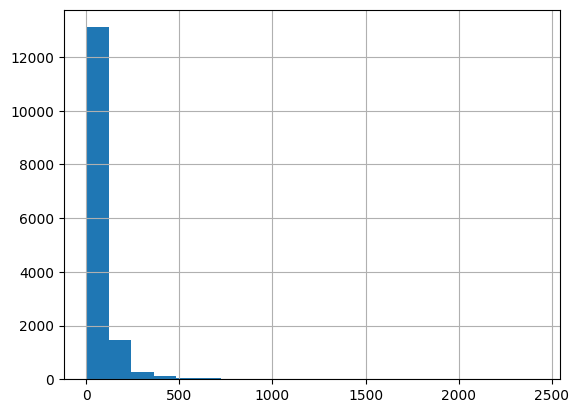

In [206]:
X.apply(lambda x: len(x.split())).hist(bins=20)

(2711,)

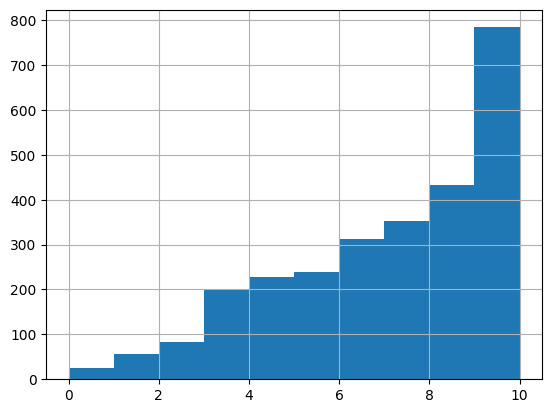

In [207]:
lower= 0
upper= 10
df_words = X.str.split()
X = X[(df_words.apply(len)>=lower) & (df_words.apply(len)<=upper)].reset_index(drop=True)
X.apply(lambda x: len(x.split())).hist()
X.shape

keep most popular words

In [208]:
counter = Counter(' '.join(X).split()).most_common()
counter[:10]

[('в', 577),
 ('как', 425),
 ('не', 252),
 ('а', 246),
 ('и', 242),
 ('на', 227),
 ('у', 162),
 ('что', 158),
 ('с', 147),
 ('я', 142)]

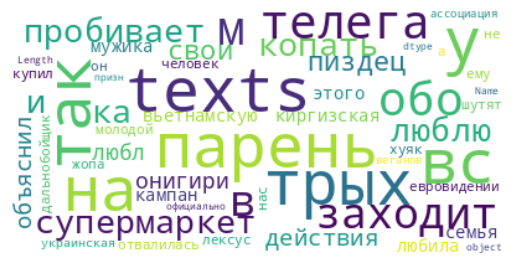

In [209]:
text = ''.join(str(X))
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [210]:
threshold = 0
bag_of_words = [x[0] for x in counter if x[1]>=threshold]
len(bag_of_words)

7779

In [211]:
import pandas as pd

In [212]:
#jokes_oft = X[(X.str.split()).apply(lambda x: pd.Series(x).isin(bag_of_words).all())]
jokes_oft = X[X.apply(lambda x: pd.Series(x.split()).isin(bag_of_words).all())]

<ipython-input-212-6ab470384563>:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  jokes_oft = X[X.apply(lambda x: pd.Series(x.split()).isin(bag_of_words).all())]


In [213]:
jokes_oft.reset_index(drop=True, inplace=True)
jokes_oft[:5]

0                                                texts
1                                   телега вс обо вс м
2    заходит парень в супермаркет и пробивает на ка...
3                                  копать люблю пиздец
4    свои действия парень объяснил так онигири любл...
Name: texts, dtype: object

In [214]:
class Vocab:
  def __init__(self, data):
    tokens = {'<sos>', '<eos>', '<unk>', '<pad>'}
    self.max_seq_len = 0
    for text in data:
      words = text.split()
      self.max_seq_len = max(self.max_seq_len, len(words) + 2) 
      tokens.update(words)

    self.idx_to_token = {idx: token for idx, token in enumerate(tokens)}
    self.token_to_idx = {token: idx for idx, token in self.idx_to_token.items()}

    self.vocab_len = len(self.idx_to_token)

In [215]:
vocab = Vocab(jokes_oft)
vocab.vocab_len, vocab.max_seq_len

(7783, 12)

In [216]:
class JokeDataset(Dataset):
  def __init__(self, X, vocab: Vocab):
    self.X = X
    self.vocab = vocab

  def vectorize(self, text):
    words = text.split()
    vec = []
    vec.append(self.vocab.token_to_idx['<sos>'])

    for word in words:
      vec.append(self.vocab.token_to_idx.get(word,
                                             self.vocab.token_to_idx['<unk>']))
    vec.append(self.vocab.token_to_idx['<eos>'])

    while len(vec) <= self.vocab.max_seq_len:
      vec.append(self.vocab.token_to_idx['<pad>'])

    return vec

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    X_vec = self.vectorize(self.X[idx][:self.vocab.max_seq_len])
    # X_vec = self.vectorize(self.X[idx])
    y_vec = X_vec[1:] + [self.vocab.token_to_idx['<pad>']]
    return tensor(X_vec), tensor(y_vec)

In [217]:
ds = JokeDataset(X, vocab)

In [218]:
batch_size = 64
dl = DataLoader(ds, batch_size=batch_size)

In [219]:
X

0                                                   texts
1                                      телега вс обо вс м
2       заходит парень в супермаркет и пробивает на ка...
3                                     копать люблю пиздец
4       свои действия парень объяснил так онигири любл...
                              ...                        
2706    киргизская семья так любила вьетнамскую кампан...
2707        у этого мужика на евровидении отвалилась жопа
2708                       молодой человек у нас не шутят
2709    купил дальнобойщик лексус а он ему трых трых хуяк
2710    украинская ассоциация веганов официально призн...
Name: texts, Length: 2711, dtype: object

In [220]:
vocab

In [221]:
class Model(Module):

  def __init__(self, vol, emb, hid, bat, seq):
    super().__init__()
    self.vol = vol
    self.emb = emb
    self.hid = hid
    self.bat = bat
    self.seq = seq

    self.embedding = Embedding(vol, emb)
    self.gru = LSTM(emb, hid,
                   num_layers = 1,
                   batch_first = True)
    self.dense = Linear(hid, vol)

  def forward(self, x, h):

    x = self.embedding(x)

    x, h = self.gru(x, h)

    x = x.reshape(-1, self.hid)

    x = self.dense(x)

    return x, h

In [222]:
model = Model(vol = vocab.vocab_len,
              emb = 400,
              hid = 400,
              bat = batch_size,
              seq = vocab.max_seq_len)

loss = CrossEntropyLoss()
optimizer = Adam(model.parameters(),
                 lr=0.01)

In [223]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


In [224]:
model.to(device)

Model(
  (embedding): Embedding(7783, 400)
  (gru): GRU(400, 400, batch_first=True)
  (dense): Linear(in_features=400, out_features=7783, bias=True)
)

In [225]:
num_epochs = 80
mse = []
h = None
for epoch in range(num_epochs):
  loss_era = []
  for x, y in dl:
    x,y = x.to(device), y.to(device)
    out, hn = model(x, h)

    batch_loss = loss(out, y.reshape(-1))

    batch_loss.backward()
    
    optimizer.step()
    optimizer.zero_grad()
    
    loss_era.append(batch_loss.item())
  loss_era = sum(loss_era)/len(loss_era)
  print(f'epoch: {epoch}, loss: {round(loss_era, 4)}')
  mse.append(loss_era)

epoch: 0, loss: 1.4731
epoch: 1, loss: 0.9827
epoch: 2, loss: 0.8995
epoch: 3, loss: 0.8356
epoch: 4, loss: 0.7848
epoch: 5, loss: 0.7524
epoch: 6, loss: 0.7339
epoch: 7, loss: 0.7302
epoch: 8, loss: 0.7227
epoch: 9, loss: 0.7154
epoch: 10, loss: 0.7088
epoch: 11, loss: 0.7052
epoch: 12, loss: 0.699
epoch: 13, loss: 0.6975
epoch: 14, loss: 0.6944
epoch: 15, loss: 0.693
epoch: 16, loss: 0.6894
epoch: 17, loss: 0.6901
epoch: 18, loss: 0.6855
epoch: 19, loss: 0.6861
epoch: 20, loss: 0.6791
epoch: 21, loss: 0.6782
epoch: 22, loss: 0.6796
epoch: 23, loss: 0.6783
epoch: 24, loss: 0.6772
epoch: 25, loss: 0.6757
epoch: 26, loss: 0.6756
epoch: 27, loss: 0.6759
epoch: 28, loss: 0.6728
epoch: 29, loss: 0.6717
epoch: 30, loss: 0.671
epoch: 31, loss: 0.6666
epoch: 32, loss: 0.6643
epoch: 33, loss: 0.6623
epoch: 34, loss: 0.6605
epoch: 35, loss: 0.6618
epoch: 36, loss: 0.659
epoch: 37, loss: 0.6576
epoch: 38, loss: 0.6542
epoch: 39, loss: 0.6562
epoch: 40, loss: 0.6588
epoch: 41, loss: 0.6995
epoch:

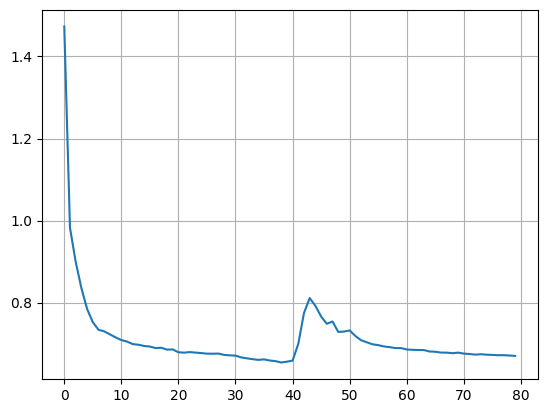

In [226]:
plt.plot(mse)
plt.grid()

In [227]:
from torch import normal, argmax, no_grad, random
from  numpy.random import choice
from random import choices

In [228]:
jokes_oft[jokes_oft.str.startswith('')].values

array(['texts', 'телега вс обо вс м',
       'заходит парень в супермаркет и пробивает на кассе двоечку', ...,
       'молодой человек у нас не шутят',
       'купил дальнобойщик лексус а он ему трых трых хуяк',
       'украинская ассоциация веганов официально признала сало растением'],
      dtype=object)

In [275]:
def gen_joke(part = []):
  name = [vocab.token_to_idx['<sos>']] + \
         [vocab.token_to_idx.get(l, vocab.token_to_idx['<unk>']) for l in part]

  # начальное состояние скрытого слоя случайное, 
  # из-за чего становится возможна случайная генерация слов
  # при условии, что первое слово - метка начала строки
  h_t = normal(0,1, size = (1, 1, 400)).to(device)

  # состояние скрытого слоя обновляется,
  # на основе заданных первых слов текста
  for l in name:
    with no_grad():
      token_dist, h_t = model(tensor([l]).reshape(1,-1).to(device), h_t)

  # на основе последних слова и состояния скрытого слоя
  # генерируются новые слово и состояние скрытого слоя 

  k = 0
  while True:
    k += 1
    with no_grad():
      token_dist, h_t = model(tensor([name[-1]]).reshape(1,-1).to(device), h_t)
      token_dist = token_dist.cpu()
      #print(a(token_dist).size())
      token = argmax(token_dist, dim = 1) # заменить аргмакс на выбор
      #print(len(token_dist[0,]))
      #print(token_dist[0,:]+token_dist[0,:].min())

      #token = choices(list(range(len(token_dist[0,:]))), weights=token_dist[0,:]+abs(token_dist[0,:].min()))

      #print(token)
      name += token.tolist()
      
      if k == 15:
        break

  name = ' '.join(vocab.idx_to_token[x] for x in name)
  name = name.replace('<sos>', '')
  name = name.replace('<eos>', '')
  name = name.replace('<pad>', '')
  name = name.replace('<unk>', '?')
  return name

no jokes from dataset - success


In [278]:
gen_joke()

заходят пупа и лупа дурак твой как раз
